#### Example using DEMReg and SDO/AIA data
Here using synthetic SDO/AIA data for a single "pixel" generated from a Gaussian DEM 

17-Aug-2020 IGH\
03-Feb-2021 IGH - Updated using new dn2dem_pos_selfnorm function\
16-Jun-2021 IGH - Updated to work with fixed dn2dem_pos, which can do selfnorm, gloci or user wght


In [1]:
# Import some of the stuff we will need
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as io
from dn2dem_pos import dn2dem_pos

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

In [2]:
# Load in the SSWIDL generated response functions
# Was produced by make_aiaresp_forpy.pro (can't escape sswidl that easily....)
trin=io.readsav('aia_tresp_en.dat')

# Get rid of the b in the string name (byte vs utf stuff....)
for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
print(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,nf))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]
matplotlib.rcParams['font.size'] = 16

['A94' 'A131' 'A171' 'A193' 'A211' 'A335']


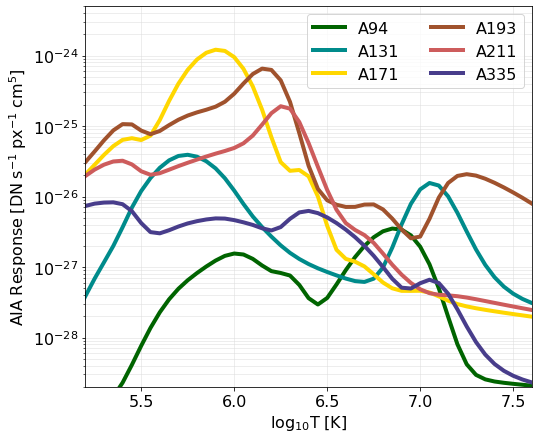

In [3]:
# Check the response look correct by plotting them
# Setup some AIA colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue']

# Do the plot
fig = plt.figure(figsize=(8, 7))
for i in np.arange(6):
    plt.semilogy(tresp_logt,trmatrix[:,i],label=trin['channels'][i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{AIA\;Response\;[DN\;s^{-1}\;px^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.2,7.6])
plt.legend(ncol=2,prop={'size': 16})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()

In [4]:
# For some DEM model (i.e. a Gaussian) produce the synthetic DN/s/px for each AIA channel
d1=4e22
m1=6.5
s1=0.15
root2pi=(2.*math.pi)**0.5
dem_mod=(d1/(root2pi*s1))*np.exp(-(tresp_logt-m1)**2/(2*s1**2))

# # Check what the DEM model looks like
# fig = plt.figure(figsize=(8, 4.5))
# plt.plot(tresp_logt,dem_mod)
# plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
# plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
# plt.ylim([2e20,4e23])
# plt.xlim([5.7,7.2])
# plt.rcParams.update({'font.size': 16})
# plt.yscale('log')
# plt.show()

# Now work out the DN/s/px
# For AIA responses all are dlogt=0.05
tresp_dlogt=np.full(nt,0.05)
tc_full=np.zeros([nt,nf])
for i in range(0,nf):
    tc_full[:,i]=dem_mod*trmatrix[:,i]*10**tresp_logt*np.log(10**tresp_dlogt)

dn_in=np.sum(tc_full,0)
print('dn_in: ',dn_in)

# And the associated uncertainty (no systematics)
gains=np.array([18.3,17.6,17.7,18.3,18.3,17.6])
dn2ph=gains*np.array([94,131,171,193,211,335])/3397.
rdnse=np.array([1.14,1.18,1.15,1.20,1.20,1.18])
# assume all obs were 2.9s long
dn0=dn_in*2.9
shotnoise=(dn2ph*dn0)**0.5/dn2ph/2.9
# error in DN/s/px
edn_in=(rdnse**2+shotnoise**2)**0.5 
print('edn_in: ',edn_in)

dn_in:  [  326.11015434   313.31711078  2663.51032758 11361.19773432
  8700.35614133  1208.36625462]
edn_in:  [14.94543538 12.67184957 32.12696435 61.39593311 51.38885685 15.53907416]


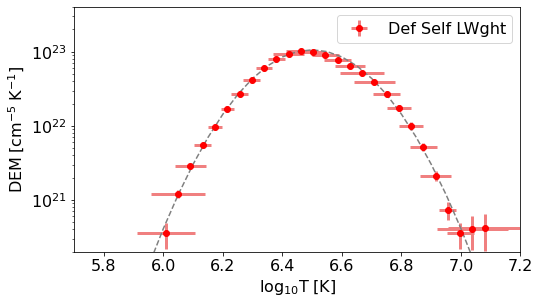

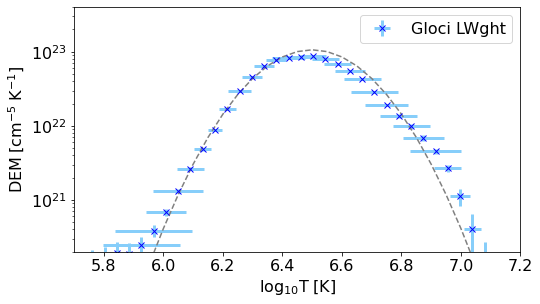

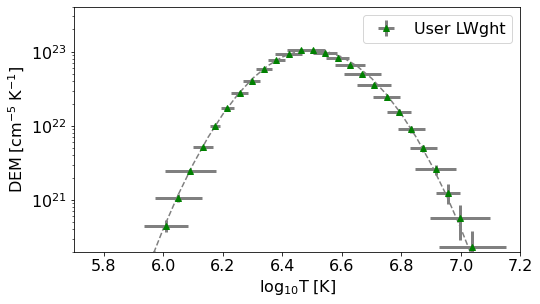

In [5]:
#  Setup the T binning for DEM solution
temps=np.logspace(5.7,7.1,num=35)
# Temperature bin mid-points for DEM plotting
mlogt=([np.mean([(np.log10(temps[i])),np.log10((temps[i+1]))]) \
        for i in np.arange(0,len(temps)-1)])

# Now work out the DEM - here as the 3 standard ways of running
# 1. Default - reg runs twice, 1st time to work out weight for constraint matrix, then regs with that
#         Best option if don't know what doing, hence its the default 
dem0,edem0,elogt0,chisq0,dn_reg0=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps) #gloci=0 is default behaviour
# 2. EMloci - reg runs once, works out weight for constraint matrix as min of EM Loci, then regs with that
#        If some of your filters have a sharper T response (lines or X-ray obs) might be useful to try
dem1,edem1,elogt1,chisq1,dn_reg1=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,gloci=1)
# 3. User weight - reg runs once, user provide weight for constraint matrix L, then regs with that
#         If have an idea of what DEM might look like could try a rough form of it (though check vs 1, 2 above)
# As working with synthetic data from DEM model, could try weighting by this model, interp on output DEM T bins
demwght0=10**np.interp(mlogt,tresp_logt,np.log10(dem_mod))
dem2,edem2,elogt2,chisq2,dn_reg2=dn2dem_pos(dn_in,edn_in,trmatrix,tresp_logt,temps,dem_norm0=demwght0/max(demwght0))

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem0,xerr=elogt0,yerr=edem0,fmt='or',\
             ecolor='lightcoral', elinewidth=3, capsize=0,label='Def Self LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e20,4e23])
plt.xlim([5.7,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiasyn_slw.png',bbox_inches='tight')
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem1,xerr=elogt1,yerr=edem1,fmt='xb',\
             ecolor='lightskyblue', elinewidth=3, capsize=0,label='Gloci LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e20,4e23])
plt.xlim([5.7,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiasyn_glw.png',bbox_inches='tight')
plt.show()

#  Plot it all
fig = plt.figure(figsize=(8, 4.5))
plt.errorbar(mlogt,dem2,xerr=elogt2,yerr=edem2,fmt='^g',\
             ecolor='grey', elinewidth=3, capsize=0,label='User LWght')
plt.plot(tresp_logt,dem_mod,'--',color='grey')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e20,4e23])
plt.xlim([5.7,7.2])
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.legend()
# plt.savefig('demregpy_aiasyn_ulw.png',bbox_inches='tight')
plt.show()


Def Self, chisq:  2.69469200848726
Gloci, chisq:  25.104835281231875
User, chisq:  1.2120380096384873
Def Self:  [0.97006789 0.99393826 1.00063899 0.99930234 0.9999341  0.949047  ]
Gloci:  [0.87628124 1.01603489 1.00117656 1.00054829 0.98655348 0.84894421]
User:  [0.94922148 0.99539077 0.99958743 0.99948788 0.99981862 0.96844683]


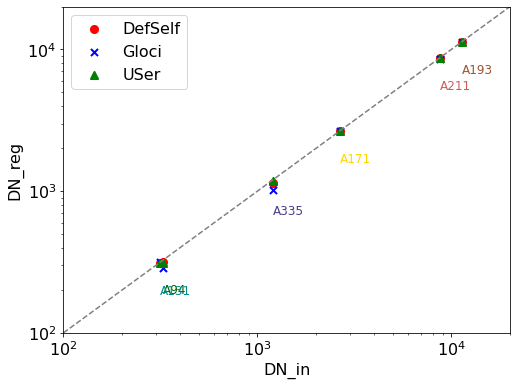

In [6]:
#  How well did they actually do?
print('Def Self, chisq: ',chisq0) # Not bad....
print('Gloci, chisq: ',chisq1) # Worse of 3 but expected as just working with AIA filters here
print('User, chisq: ',chisq2) # Know the answer so unsurprising this LWght gives best answer!

print('Def Self: ',dn_reg0/dn_in)
print('Gloci: ',dn_reg1/dn_in)
print('User: ',dn_reg2/dn_in)

fig,ax = plt.subplots(figsize=(8, 6))
plt.scatter(dn_in,dn_reg0,color='red',marker='o',s=50,lw=2,label='DefSelf')
plt.scatter(dn_in,dn_reg1,color='blue',marker='x',s=50,lw=2,label='Gloci')
plt.scatter(dn_in,dn_reg2,color='green',marker='^',s=50,lw=2,label='USer')
for i, lab in enumerate(trin['channels']):
    ax.annotate(lab, (dn_in[i], 0.6*dn_reg0[i]),color=clrs[i],fontsize=12)
plt.xlabel('DN_in')
plt.ylabel('DN_reg')
xyrang=[1e2,2e4]
plt.plot(xyrang,xyrang,color='grey',ls='dashed')
plt.ylim(xyrang)
plt.xlim(xyrang)
plt.rcParams.update({'font.size': 16})
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()